In [ ]:
%autosave 60

Autosaving every 60 seconds


### GitHub Link: https://github.com/AnkitaSavaliya/AIH/blob/main/MIMIC_Visualization.ipynb

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load patients data
d1 = files.upload()
patients = pd.read_csv('PATIENTS.csv')
#patients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/PATIENTS.csv')

Saving PATIENTS.csv to PATIENTS.csv


In [ ]:
# Load admissions data
d2 = files.upload()
admissions = pd.read_csv('ADMISSIONS.csv')
#admissions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/ADMISSIONS.csv')

Saving ADMISSIONS.csv to ADMISSIONS.csv


In [ ]:
# Load diagnoses_icd data
d3 = files.upload()
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
#diagnoses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/DIAGNOSES_ICD.csv')

Saving DIAGNOSES_ICD.csv to DIAGNOSES_ICD.csv


In [ ]:
# Load D_ICD_DIAGNOSES data
d4 = files.upload()
diagnoses_labels = pd.read_csv('D_ICD_DIAGNOSES.csv')
#diagnoses_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/D_ICD_DIAGNOSES.csv')

Saving D_ICD_DIAGNOSES.csv to D_ICD_DIAGNOSES.csv


In [ ]:
# Load ICUSTAYS data
d5 = files.upload()
icustays = pd.read_csv('ICUSTAYS.csv')
#icustays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/ICUSTAYS.csv')
#icustays.head(2)

Saving ICUSTAYS.csv to ICUSTAYS.csv


In [ ]:
# Load PRESCRIPTIONS data
d6 = files.upload()
prescriptions = pd.read_csv('PRESCRIPTIONS.csv')
#prescriptions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMICIIITables/PRESCRIPTIONS.csv')

Saving PRESCRIPTIONS.csv to PRESCRIPTIONS.csv


In [ ]:
from datetime import datetime

df = patients
# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
df["age"] = df.apply(lambda row: calculate_age(row["dob"], row["dod"]), axis=1)

# Filter out rows with age greater than or equal to 120
filtered_df = df[df["age"] < 120]

# Display the updated DataFrame
print(filtered_df.head(1))

   row_id  subject_id gender                  dob                  dod  \
0    9467       10006      F  2094-03-05 00:00:00  2165-08-12 00:00:00   

              dod_hosp              dod_ssn  expire_flag  age  
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1   71  


In [ ]:
# Merge admissions and patients data on subject_id
merged_data = pd.merge(filtered_df, admissions, on='subject_id')
merged_data.head(1)

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,row_id_y,...,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,71,12258,...,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1


In [ ]:
# Merge diagnosis_icd with admissions on subject_id
merged_data_diagnosis = pd.merge(merged_data, diagnoses, on='subject_id', how='inner')
merged_data_diagnosis.head(1)

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,row_id_y,...,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,row_id,hadm_id_y,seq_num,icd9_code
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,71,12258,...,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,112344,142345,1,99591


In [ ]:
# Convert the DataFrame to a dictionary to link icd9 codes to respective labels
icd9_dict = diagnoses_labels.set_index('icd9_code')['short_title'].to_dict()

# Print the dictionary
#print(icd9_dict)

In [ ]:
merged_data_diagnosis['icd9_code'].value_counts().head(5) #Top 5 diagnosed icd code


,count
icd9_code,
4019,250
42731,221
2449,202
5849,191
3572,181


### Plot-1 : Age and Gender-wise Distribution of Diabetes Patients

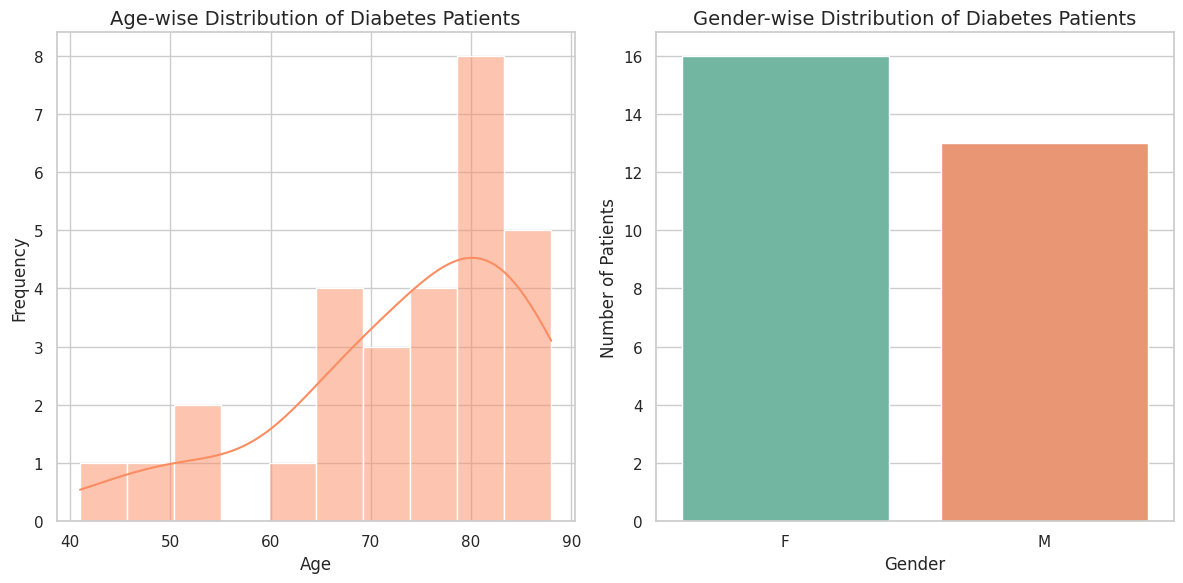

In [ ]:
# Filter for diabetes patients based on ICD-9 codes (250.x series)
diabetes_patients = merged_data_diagnosis[merged_data_diagnosis['icd9_code'].str.startswith('250')]

# Drop duplicate subject IDs to avoid double-counting patients
unique_diabetes_patients = diabetes_patients.drop_duplicates(subset='subject_id')

# Count gender distribution
gender_counts = unique_diabetes_patients['gender'].value_counts()

#set seaborn theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Age-wise distribution using histplot
plt.subplot(1, 2, 1)
sns.histplot(data=unique_diabetes_patients, x='age', bins=10, kde=True, color=sns.color_palette("Set2")[1])
plt.title("Age-wise Distribution of Diabetes Patients", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=0)

# Gender-wise distribution using barplot
plt.subplot(1, 2, 2)
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index, palette="Set2", legend=False)
plt.title('Gender-wise Distribution of Diabetes Patients', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Plot-2 : Proportional Distribution of Heart Failure Subtypes by ICD-9 Code

In [ ]:
import plotly.express as px

# Filter for Heart patients based on ICD-9 codes (428.x series)
heart_patients = merged_data_diagnosis[merged_data_diagnosis['icd9_code'].str.startswith('428')]

# Drop duplicate subject IDs to avoid double-counting patients
unique_heart_patients = heart_patients.drop_duplicates(subset='subject_id')

# Prepare icd code - short description labels
icd9_counts = unique_heart_patients['icd9_code'].value_counts()
icd9_labels = [f"{code} - {desc}" for code, desc in zip(icd9_counts.index, icd9_counts.index.map(icd9_dict))]
icd9_data = pd.DataFrame({'ICD-9 Code': icd9_counts.index, 'Description': icd9_labels, 'Count': icd9_counts.values})
#print(icd9_data)

# Set pull value for slice effect
pull_values = [0.1 if i < 3 else 0 for i in range(len(icd9_data))]

# Create a Pie chart using Plotly Express with a modern color palette
fig = px.pie(icd9_data, names='Description', values='Count',
             title='Proportional Distribution of Heart Failure Subtypes by ICD-9 Code',
             color='Description',
             color_discrete_sequence=px.colors.sequential.Viridis)  # Modern Plasma color scheme

# Adding the slice effect
fig.update_traces(hole=0.3, pull=pull_values)
# Align title to center
fig.update_layout(title_x=0.4)
# Show the chart
fig.show()

# Plot-3 : Word Cloud of the Top 50 Most Prescribed Medicines

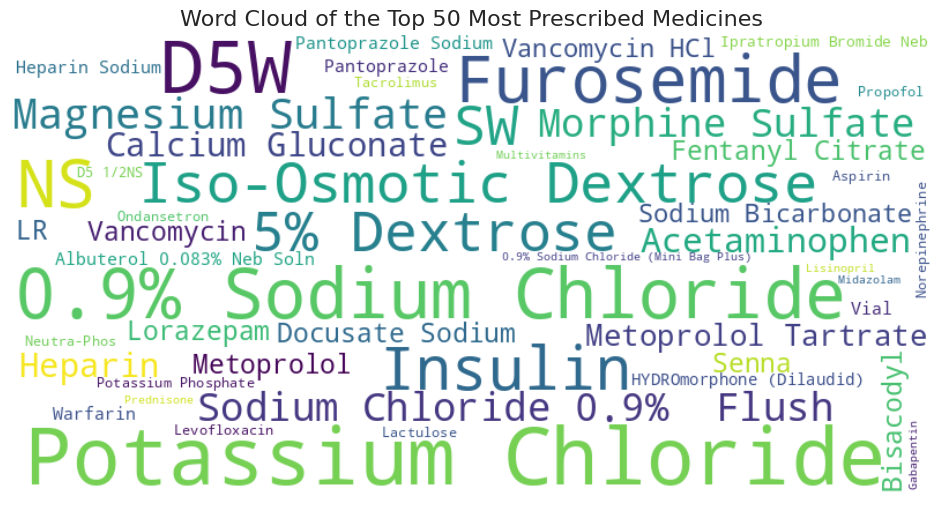

In [ ]:
from wordcloud import WordCloud

# Extract the top 50 medication names and counts
medication_counts = prescriptions['drug'].value_counts(ascending=False)
top_prescribed_meds = medication_counts.head(50)
#print(medication_counts.head(5))

# Generate the word cloud using the top prescribed medications directly
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top_prescribed_meds)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Top 50 Most Prescribed Medicines', fontsize=16)
plt.show()

In [ ]:
#merged_data_diagnosis.head(2)

# Plot-4 : Average Length Of Stay by Care Unit and Year (Filtered by ICD Code)

In [ ]:
import altair as alt

# Average Length of Stay by Care Unit and Year (Can be Filtered by ICD Code)

# Convert 'intime' and 'outtime' to datetime
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# Extract the year from 'intime'
icustays['intime_year'] = icustays['intime'].dt.year

# Merge icustays with ICD-9 diagnosis codes
icustays_with_icd = icustays.merge(diagnoses, on='hadm_id', how='left')

# Calculate the mean LOS for each care unit and year
los_stats = icustays_with_icd.groupby(['first_careunit', 'intime_year', 'icd9_code'])['los'].mean().reset_index()

# Create a list of 'ICD9 code - short description' for each unique ICD9 code
icd_label_options = [(code, f" {icd9_dict.get(code, 'Unknown description')}") for code in los_stats['icd9_code'].unique()]

# Create a selection widget for ICD-9 codes
icd_selection = alt.selection_point(
    fields=['icd9_code'],
    bind=alt.binding_select(options=icd_label_options, name="Select ICD Code ")
)

# Create the Altair chart
chart = alt.Chart(los_stats).mark_line(point=True).encode(
    x=alt.X('intime_year:O', title='Year'),
    y=alt.Y('los:Q', title='Mean Length of Stay (LOS)'),
    color=alt.Color('first_careunit:N', title='Care Unit'),
    tooltip=['first_careunit', 'intime_year', 'los', 'icd9_code']  # Add tooltips for interactivity
).add_params(
    icd_selection
).transform_filter(
    icd_selection

).properties(
    title='Average Length Of Stay by Care Unit and Year (Filtered by ICD Code)',
    width=800,
    height=400
)

# Display the chart
chart


alt.Chart(...)

# Plot-5 : Analysis of Death Counts by Diagnosis and Gender

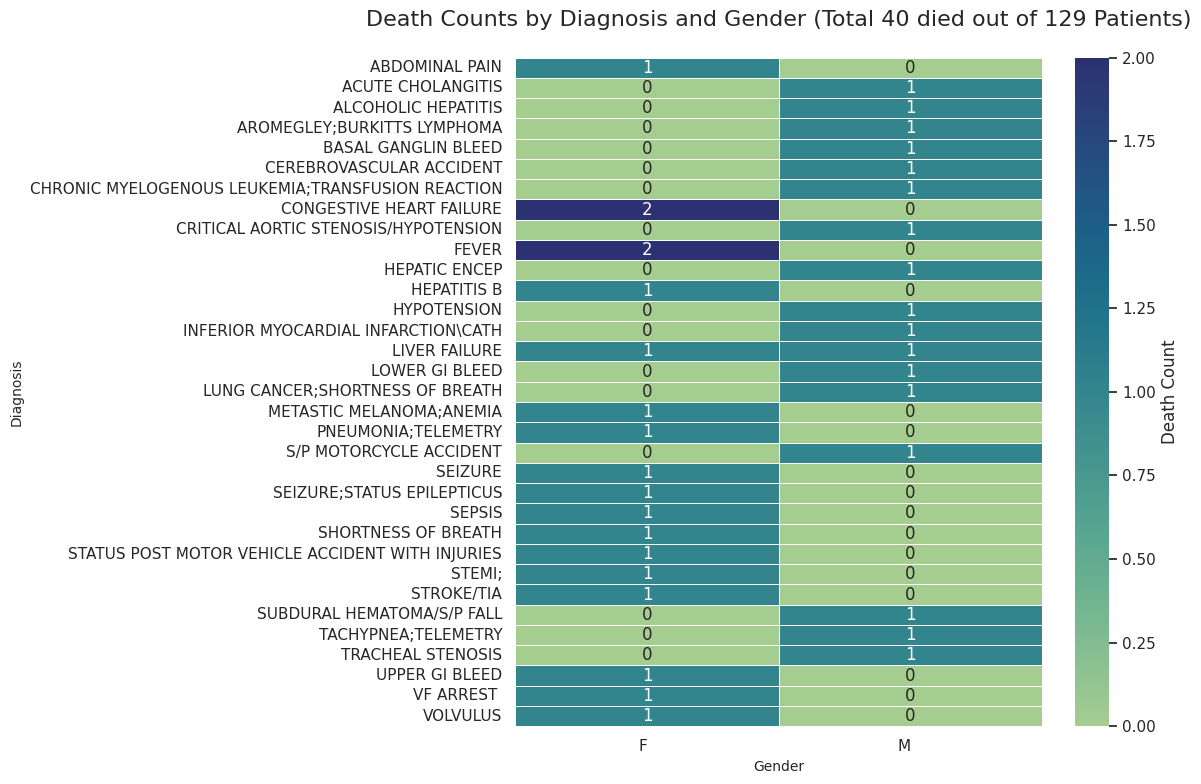

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for deceased patients
deceased = merged_data[merged_data['discharge_location'] == 'DEAD/EXPIRED']

# Calculate total patients and deceased patients
total_patients = len(admissions)
total_deceased = len(admissions[admissions['discharge_location'] == 'DEAD/EXPIRED'])

# Group deceased data by diagnosis and gender
deaths_by_diagnosis = deceased.groupby(['diagnosis', 'gender']).size().reset_index(name='death_count')
deaths_by_diagnosis = deaths_by_diagnosis.sort_values(by='death_count', ascending=False)

# Prepare heatmap data
heatmap_data = deaths_by_diagnosis.pivot_table(
    index='diagnosis',
    columns='gender',
    values='death_count',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="crest", cbar_kws={'label': 'Death Count'}, linewidths=0.5)

# Add title and labels
plt.title(f'Death Counts by Diagnosis and Gender (Total {total_deceased} died out of {total_patients} Patients)\n', fontsize=16)
plt.xlabel('Gender', fontsize=10)
plt.ylabel('Diagnosis', fontsize=10)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


# Plot-6 : Insurance Analysis based on Gender and Marital Status

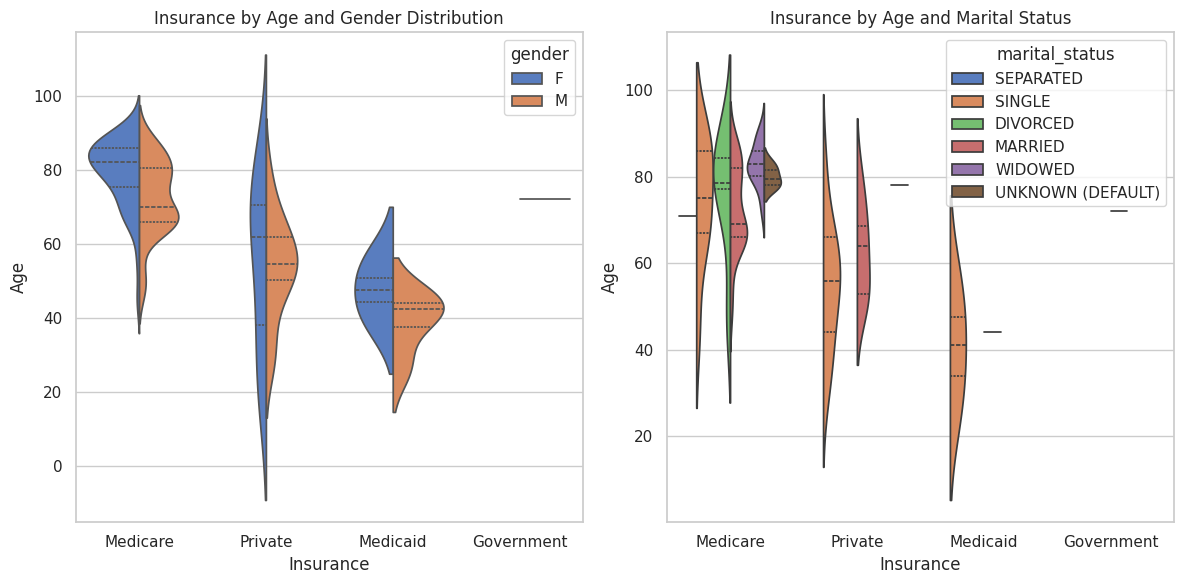

In [ ]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create a figure and set its size
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=merged_data, x='insurance', y='age', hue='gender', split=True, inner='quart', palette="muted")
plt.title("Insurance by Age and Gender Distribution")
plt.xlabel("Insurance")
plt.ylabel("Age")

plt.subplot(1, 2, 2)
sns.violinplot(data=merged_data, x='insurance', y='age', hue='marital_status', split=True, inner='quart', palette="muted")
plt.title("Insurance by Age and Marital Status")
plt.xlabel("Insurance")
plt.ylabel("Age")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()